In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np

In [9]:
%matplotlib inline

In [10]:
sns.set(rc={'figure.figsize': (11.7, 8.27)}, style="white", color_codes=True)
plt.rc('pdf', fonttype=42)  # Embed font

In [11]:
def convert_time(log_df):
    if len(log_df.time_unit.unique()) > 1:
            raise ValueError('Mixed time units')
    time_unit = log_df.time_unit.unique()[0]
    if time_unit == 'ms':
        log_df.cpu_time = log_df.cpu_time/(10**3)  # ms to s
        log_df.real_time = log_df.real_time/(10**3)
    elif time_unit == 'ns':
        log_df.cpu_time = log_df.cpu_time/(10**9)  # ns to s
        log_df.real_time = log_df.real_time/(10**9)
    else:
        raise ValueError('Unrecognised time unit')
    
def load_qtime_collsize_df(filename, collection, convert_units=True):
    query_df = pd.read_csv(filename, index_col=None)
    name_split = query_df.name.str.split('/')
    qac_impl = name_split.apply(lambda x: x[1])
    coll_size = name_split.apply(lambda x: int(x[2]))
    pqlog_nconv = name_split.apply(lambda x: int(x[3]))
    log_type = name_split.apply(lambda x: x[4])
    log_type.replace('108', 'LRLog', inplace=True)
    log_type.replace('115', 'SynthLog', inplace=True)
    
    query_df['qac_impl'] = qac_impl
    query_df['nrows'] = coll_size
    query_df['nconv'] = pqlog_nconv
    query_df['log_type'] = log_type
    query_df['collection'] = collection
    
    query_df.drop(['name','bytes_per_second','items_per_second',
                   'label','error_occurred','error_message'],
                   axis=1, inplace=True)
    
#     scaling_factor = 8
#     if query_df.iloc[-1]['nrows']/query_df.iloc[-2]['nrows'] != scaling_factor:
#         query_df = query_df[:-1] # Drop the last row
    
    if convert_units:
        if len(query_df.time_unit.unique()) > 1:
            raise ValueError('Mixed time units')
        time_unit = query_df.time_unit.unique()[0]
        if time_unit == 'ms':
            query_df.cpu_time = query_df.cpu_time/(10**3)  # ns to s
            query_df.real_time = query_df.real_time/(10**3)
        else:
            raise ValueError('Unrecognised time unit')
    
    return query_df

In [12]:
wiki_qdf = pd.read_csv('../../export/data/query-collsize/wiki.csv', index_col=None)

In [13]:
for x in wiki_qdf.tail().name.str.split('/'):
    print(x)

['Fixture<IncNgTrieCompleter>', 'IncNgTrie', '4096', '10000', '108']
['Fixture<IncNgTrieCompleter>', 'IncNgTrie', '32768', '10000', '108']
['Fixture<IncNgTrieCompleter>', 'IncNgTrie', '262144', '10000', '108']
['Fixture<IncNgTrieCompleter>', 'IncNgTrie', '2097152', '10000', '108']
['Fixture<IncNgTrieCompleter>', 'IncNgTrie', '4560699', '10000', '108']


In [14]:
wiki_csize_df = load_qtime_collsize_df('../../export/data/query-collsize/wiki.csv','wiki')
cweb_csize_df = load_qtime_collsize_df('../../export/data/query-collsize/cweb.csv','cweb')
bing_csize_df = load_qtime_collsize_df('../../export/data/query-collsize/bing.csv','bing') 

In [15]:
wiki_csize_df

,iterations,real_time,cpu_time,time_unit,CompByesInvRate,CompBytesRate,NComp,NPQ,NPQInvRate,NPQRate,PQByesInvRate,PQBytes,PQBytesRate,qac_impl,nrows,nconv,log_type,collection
0,1,2.511140,2.687500,ms,2.276260e-06,439318.000,69443,66885,0.000040,24887.40000,0.000004,651446.0,242399.0000,HTrie,512,10000,SynthLog,wiki
1,1,7.091980,7.187500,ms,3.992090e-06,250496.000,109721,66885,0.000107,9305.74000,0.000011,651446.0,90636.0000,HTrie,4096,10000,SynthLog,wiki
2,1,10.741500,10.875000,ms,4.180770e-06,239191.000,160225,66885,0.000163,6150.34000,0.000017,651446.0,59903.1000,HTrie,32768,10000,SynthLog,wiki
3,1,72.649800,72.953100,ms,2.060600e-05,48529.500,214272,66885,0.001091,916.82200,0.000112,651446.0,8929.6500,HTrie,262144,10000,SynthLog,wiki
4,1,764.199000,764.266000,ms,1.788960e-04,5589.840,263759,66885,0.011427,87.51540,0.001173,651446.0,852.3820,HTrie,2097152,10000,SynthLog,wiki
5,1,743.106000,743.156000,ms,1.739550e-04,5748.610,263759,66885,0.011111,90.00130,0.001141,651446.0,876.5940,HTrie,4560699,10000,SynthLog,wiki
6,1,4.804380,4.859380,ms,2.085170e-06,479578.000,133853,142539,0.000034,29332.80000,0.000003,1567470.0,322567.0000,HTrie,512,10000,LRLog,wiki
7,1,16.805600,16.968800,ms,4.513680e-06,221549.000,216440,142539,0.000119,8400.09000,0.000011,1567470.0,92374.2000,HTrie,4096,10000,LRLog,wiki
8,1,18.803300,18.890600,ms,3.495100e-06,286115.000,319360,142539,0.000133,7545.49000,0.000012,1567470.0,82976.3000,HTrie,32768,10000,LRLog,wiki
9,1,153.118000,153.656000,ms,2.141760e-05,46690.600,429685,142539,0.001078,927.64900,0.000098,1567470.0,10201.2000,HTrie,262144,10000,LRLog,wiki


In [16]:
# wiki_csize_df['nbytes'] = wiki_bytes
# bing_csize_df['nbytes'] = bing_bytes
# cweb_csize_df['nbytes'] = cweb_bytes

In [17]:
combined_qtime_csize = wiki_csize_df.append(cweb_csize_df,
                         ignore_index=True).append(
                         bing_csize_df, ignore_index=True)

In [18]:
def total_query_time(query_df, collection):
    total_qtime = query_df[(query_df.nrows == query_df.nrows.max()) \
              & (query_df.log_type == 'SynthLog')][['qac_impl', 'cpu_time', 'NComp', 
                                                    'CompBytesRate', 'PQBytesRate']]

    if collection == "wiki":
        total_bytes = 1.118900e+08
    elif collection == "bing":
        total_bytes = 3.173030e+08
    elif collection == "cweb":
        total_bytes = 3.494550e+09
    else :
        raise valueError("Invald collection")
   
    
    print(total_qtime)
    


In [19]:
total_query_time(wiki_csize_df, "wiki")

     qac_impl     cpu_time   NComp  CompBytesRate  PQBytesRate
5       HTrie    743.15600  263759       5748.610      876.594
17     Marisa    362.07800  263952      11778.700     1799.190
29       DAWG      1.57812  233568    2398840.000   412797.000
41  IncNgTrie  14778.70000  319711        340.969       44.080


In [20]:
total_query_time(wiki_csize_df, "wiki")

     qac_impl     cpu_time   NComp  CompBytesRate  PQBytesRate
5       HTrie    743.15600  263759       5748.610      876.594
17     Marisa    362.07800  263952      11778.700     1799.190
29       DAWG      1.57812  233568    2398840.000   412797.000
41  IncNgTrie  14778.70000  319711        340.969       44.080


In [21]:
total_query_time(bing_csize_df, "bing")

     qac_impl     cpu_time   NComp  CompBytesRate  PQBytesRate
5       HTrie    540.01600  305096       9523.760    1167.0200
17     Marisa    397.18800  305252      12756.300    1586.6800
29       DAWG      1.60938  270776    2816940.000  391587.0000
41  IncNgTrie  10931.00000  367740        556.025      57.6533


In [22]:
cweb_csize_df.nrows.unique()

array([      512,      4096,     32768,    262144,   2097152,  16777216,
       125000000])

In [23]:
cweb_csize_df.columns

Index([u'iterations', u'real_time', u'cpu_time', u'time_unit',
       u'CompByesInvRate', u'CompBytesRate', u'NComp', u'NPQ', u'NPQInvRate',
       u'NPQRate', u'PQByesInvRate', u'PQBytes', u'PQBytesRate', u'qac_impl',
       u'nrows', u'nconv', u'log_type', u'collection'],
      dtype='object')

/Users/uthoombayil/miniconda2/lib/python2.7/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


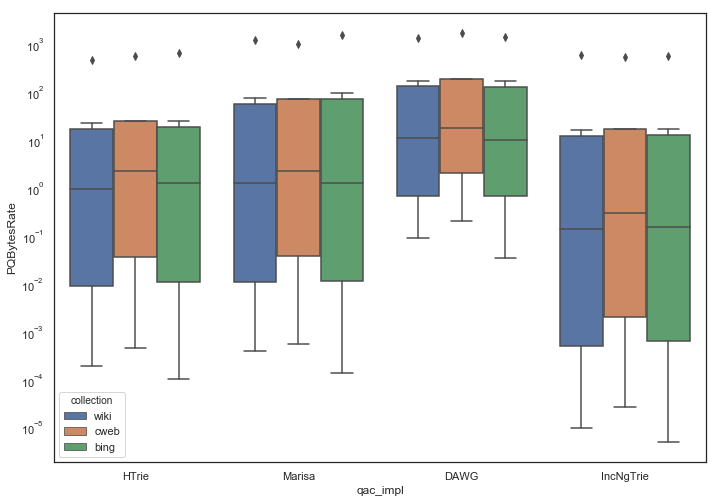

In [24]:
sliced_df = combined_qtime_csize[(combined_qtime_csize.log_type=="SynthLog")
                                  & (combined_qtime_csize.nrows <= bing_csize_df.nrows.max())   
                                ]
sliced_df.PQBytesRate = sliced_df.PQBytesRate / sliced_df.nrows
ax = sns.boxplot(x="qac_impl", y="PQBytesRate", data=sliced_df, hue="collection")
plt.yscale('log')

## Number of completions

In [25]:
combined_qtime_csize.groupby(['qac_impl', 'log_type', 'collection'])['NComp'].max()

qac_impl   log_type  collection
DAWG       LRLog     bing          548968
                     cweb          519500
                     wiki          464782
           SynthLog  bing          270776
                     cweb          262903
                     wiki          233568
HTrie      LRLog     bing          617699
                     cweb          588809
                     wiki          525867
           SynthLog  bing          305096
                     cweb          298221
                     wiki          263759
IncNgTrie  LRLog     bing          734756
                     cweb          623134
                     wiki          631211
           SynthLog  bing          367740
                     cweb          348595
                     wiki          319711
Marisa     LRLog     bing          618285
                     cweb          589149
                     wiki          526360
           SynthLog  bing          305252
                     cweb          298095
  

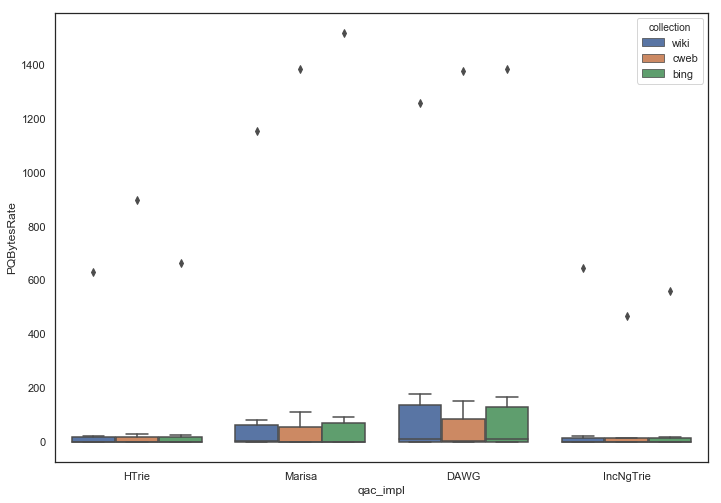

In [26]:
comb_filter = combined_qtime_csize[((combined_qtime_csize.log_type == "LRLog") & 
                                     (combined_qtime_csize.collection !="bing"))       
                                    | 
                                   ((combined_qtime_csize.collection=="bing") &
                                   (combined_qtime_csize.log_type=="SynthLog"))]
#                                   & (combined_qtime_csize.nrows <= bing_csize_df.nrows.max())]
# comb_filter = combined_qtime_csize[(combined_qtime_csize.log_type == "LRLog") ]
# (combined_qtime_csize.nrows <= bing_csize_df.nrows.max())
comb_filter.PQBytesRate = comb_filter.PQBytesRate / comb_filter.nrows
ax = sns.boxplot(x="qac_impl", y="PQBytesRate", data=comb_filter, hue="collection")
#plt.yscale('log')

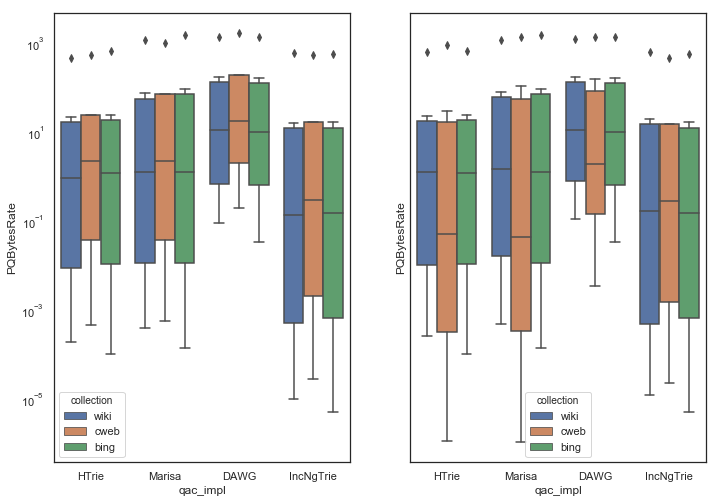

In [27]:
fig, ax = plt.subplots(1, 2, sharey=True)
sns.boxplot(x="qac_impl", y="PQBytesRate", data=sliced_df, hue="collection", ax=ax[0])
sns.boxplot(x="qac_impl", y="PQBytesRate", data=comb_filter, hue="collection", ax=ax[1])
plt.yscale('log')

# Query time $\mid P \mid $ benchmarks

In [28]:
class QACImpl : 
    htrie = 'HTrie'
    marisa = 'Marisa'
    dawg = 'DAWG'
    incngt = 'IncNgTrie'

    @staticmethod
    def qac_impl_list():
        return [QACImpl.htrie, QACImpl.marisa, QACImpl.dawg, QACImpl.incngt]

In [29]:
def map_qac_impl(s):
    for qimpl in QACImpl.qac_impl_list():
        if qimpl in s: 
            return qimpl
def load_qtime_df(filename, collection, convert_units=True):
    query_df = pd.read_csv(filename, index_col=None)
    name_split = query_df.name.str.split('/')
    
    qac_impl = name_split.apply(lambda x: x[1])
    coll_size = name_split.apply(lambda x: int(x[2]))
    pqlog_nconv = name_split.apply(lambda x: int(x[3]))
    log_type = name_split.apply(lambda x: x[4])
    log_type.replace('108', 'LRLog', inplace=True)
    log_type.replace('115', 'SynthLog', inplace=True)

    
    query_df['qac_impl'] = qac_impl
    query_df['nrows'] = coll_size
    query_df['nconv'] = pqlog_nconv
    query_df['log_type'] = log_type
    query_df['collection'] = collection
    
    query_df.drop(['name','bytes_per_second','items_per_second',
                   'label','error_occurred','error_message'], axis=1, inplace=True)

    query_df.qac_impl = query_df.qac_impl.apply(lambda x: map_qac_impl(x))
    
    if convert_units:
        if len(query_df.time_unit.unique()) > 1:
            raise ValueError('Mixed time units')
        time_unit = query_df.time_unit.unique()[0]
        if time_unit == 'ms':
            query_df.cpu_time = query_df.cpu_time/(10**3)  # ns to s
            query_df.real_time = query_df.real_time/(10**3)
        else:
            raise ValueError('Unrecognised time unit')
    
    return query_df

In [30]:
wiki_qtime_df = load_qtime_df('../../export/data/query-plen/wiki-query-times.csv', 'wiki')
bing_qtime_df = load_qtime_df('../../export/data/query-plen/bing-query-times.csv', 'bing')
cweb_qtime_df = load_qtime_df('../../export/data/query-plen/cweb-query-times.csv', 'cweb')

In [31]:
wiki_qtime_df

,iterations,real_time,cpu_time,time_unit,CompByesInvRate,CompBytesRate,NComp,NPQ,NPQInvRate,NPQRate,PQByesInvRate,PQBytes,PQBytesRate,qac_impl,nrows,nconv,log_type,collection
0,1,1472.30000,1471.30000,ms,3.230950e-04,3095.070,282018,66885,0.022013,45.42880,0.002260,651446.0,442.4670,HTrie,4560699,100000,SynthLog,wiki
1,1,2812.47000,2810.25000,ms,3.008890e-04,3323.480,559973,142539,0.019731,50.68100,0.001794,1567470.0,557.3300,HTrie,4560699,100000,LRLog,wiki
2,1,725.06300,723.95300,ms,1.591130e-04,6284.860,282018,66885,0.010840,92.24720,0.001113,651446.0,898.4680,Marisa,4560699,100000,SynthLog,wiki
3,1,1432.54000,1430.61000,ms,1.532580e-04,6524.940,559973,142539,0.010050,99.50080,0.000914,1567470.0,1094.1900,Marisa,4560699,100000,LRLog,wiki
4,1,2.32439,1.51562,ms,5.792440e-07,1726390.000,249437,66885,0.000035,28775.20000,0.000004,651446.0,280265.0000,DAWG,4560699,100000,SynthLog,wiki
5,1,4.76169,2.92188,ms,5.785830e-07,1728360.000,494965,142539,0.000033,29934.60000,0.000003,1567470.0,329185.0000,DAWG,4560699,100000,LRLog,wiki
6,1,26920.20000,26912.70000,ms,5.134030e-03,194.779,335315,66885,0.402485,2.48457,0.041324,651446.0,24.1992,IncNgTrie,4560699,100000,SynthLog,wiki
7,1,54725.60000,54712.30000,ms,5.171510e-03,193.367,660770,142539,0.383934,2.60461,0.034913,1567470.0,28.6424,IncNgTrie,4560699,100000,LRLog,wiki


In [32]:
combined_qtime_df =     wiki_qtime_df.append(
                                cweb_qtime_df, ignore_index=True).append(
                                bing_qtime_df, ignore_index=True)

In [34]:
combined_qtime_df[combined_qtime_df.log_type=='LRLog'][['collection', 'qac_impl', 'cpu_time','PQBytesRate', 'NPQ']]

,collection,qac_impl,cpu_time,PQBytesRate,NPQ
1,wiki,HTrie,2810.25000,557.33000,142539
3,wiki,Marisa,1430.61000,1094.19000,142539
5,wiki,DAWG,2.92188,329185.00000,142539
7,wiki,IncNgTrie,54712.30000,28.64240,142539
9,cweb,IncNgTrie,302050.00000,5.12721,141873
11,cweb,HTrie,22653.90000,68.35750,141873
13,cweb,Marisa,19320.50000,80.14980,141873
15,cweb,DAWG,3.40625,289614.00000,141873
17,bing,HTrie,6924.30000,223.29300,141619
19,bing,Marisa,4292.84000,360.07900,141619


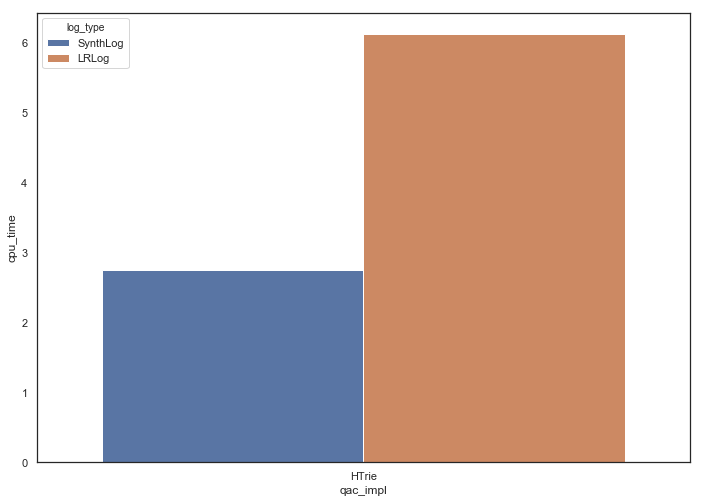

In [38]:
qtime_slice = combined_qtime_df[combined_qtime_df.qac_impl == 'HTrie']
ax = sns.barplot(x='qac_impl', y='cpu_time', hue='log_type', data=qtime_slice)
# ax.set_yscale('log')

## Querying time at various lengths of |P|

In [31]:
def load_qtime_plen_df(file_name):
    qtime_plen_df = pd.read_csv(file_name, header=None)
    qtime_plen_df.columns = ['qac_impl', 'plen', 'cpu_time', 'log_type', 'collection']
    qtime_plen_df.cpu_time = qtime_plen_df.cpu_time * 1e3 # s to ms
    qtime_plen_df.log_type = qtime_plen_df.log_type.map({115:'SynthLog', 108:'LRLog'})
    qtime_plen_df.qac_impl = qtime_plen_df.qac_impl.apply(lambda x: map_qac_impl(x))
    return qtime_plen_df


In [33]:
wiki_qtime_plen_df = load_qtime_plen_df('../../export/data/query-plen/wiki-plen-qtime.csv')
cweb_qtime_plen_df = load_qtime_plen_df('../../export/data/query-plen/cweb-plen-qtime.csv')
bing_qtime_plen_df = load_qtime_plen_df('../../export/data/query-plen/bing-plen-qtime.csv')

In [34]:
combined_qtime_plen_df = wiki_qtime_plen_df.append(
                        cweb_qtime_plen_df, ignore_index=True).append(
                        bing_qtime_plen_df, ignore_index=True)

In [42]:
def norm_plen_qtime(combined_qtime_plen_df, combined_qtime_df):
    """ Normalise the cpu_time in combined_qtime_plen_df with the curresponding
    total for the collection, qac_impl and log from combined_qtime_df."""
    for coll in combined_qtime_df.collection.unique():
        for lt in combined_qtime_df.log_type.unique():
            for qac_impl in combined_qtime_df.qac_impl:
                max_qtime = combined_qtime_df[
                                    (combined_qtime_df.qac_impl == qac_impl)
                                    & (combined_qtime_df.collection == coll)
                                    & (combined_qtime_df.log_type == lt)
                                    ][ 'cpu_time'].max()
                mask = (combined_qtime_plen_df.qac_impl == qac_impl)\
                   & (combined_qtime_plen_df.collection == coll)\
                   & (combined_qtime_plen_df.log_type)
                combined_qtime_plen_df.loc[
                    mask, 'normed_cpu_time'] = combined_qtime_plen_df[
                                                    mask]['cpu_time']/max_qtime
    


In [94]:
qac_impl = 'Marisa'
norm_plen_qtime(combined_qtime_plen_df, combined_qtime_df)

In [95]:
sliced_plendf = combined_qtime_plen_df[(combined_qtime_plen_df.qac_impl == qac_impl)]

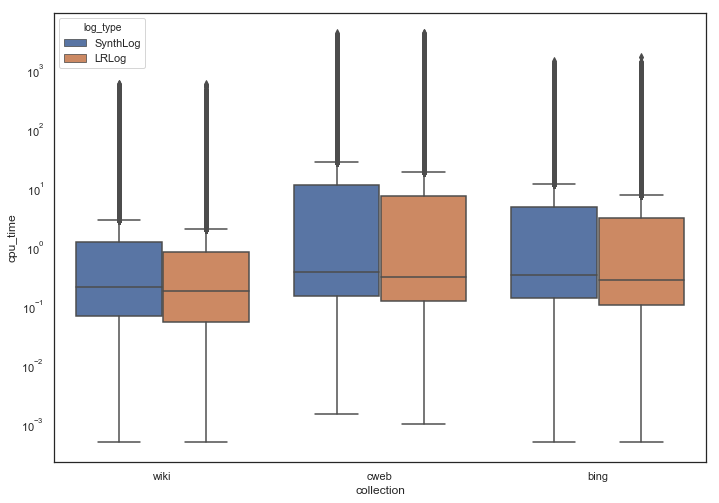

In [50]:
sns.boxplot(x='collection', y='cpu_time', data=sliced_plendf, hue='log_type')
plt.yscale('log')

In [96]:
qac_impl = 'Marisa'
sliced_plendf = combined_qtime_plen_df[(combined_qtime_plen_df.qac_impl == qac_impl)]

In [97]:
sliced_plendf[sliced_plendf.log_type == 'SynthLog']['cpu_time'].describe()

count    198542.000000
mean         64.071057
std         282.896610
min           0.000500
25%           0.002500
50%           0.022000
75%           2.854300
max        2939.130000
Name: cpu_time, dtype: float64

In [98]:
sliced_plendf[sliced_plendf.log_type == 'LRLog']['cpu_time'].describe()

count    426031.000000
mean         58.767846
std         270.840914
min           0.000500
25%           0.002000
50%           0.009800
75%           1.762200
max        3031.820000
Name: cpu_time, dtype: float64

(0, 64)

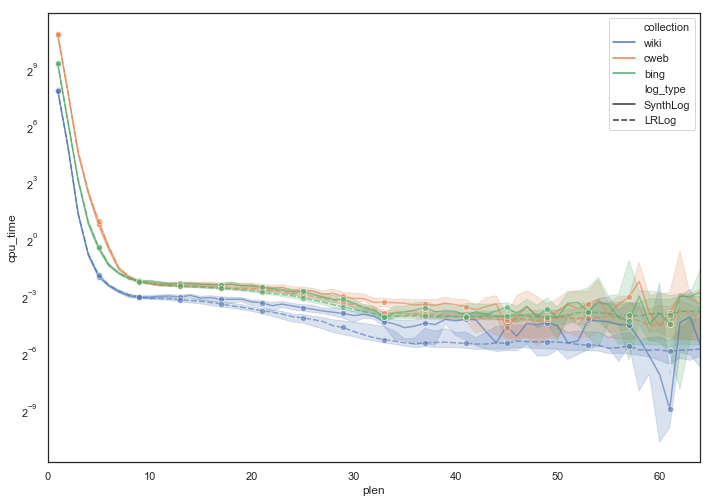

In [58]:
sliced_df = combined_qtime_plen_df[(combined_qtime_plen_df.qac_impl == qac_impl)]
ax = sns.lineplot(x='plen', y='cpu_time', hue='collection', style='log_type', data=sliced_df,
                  marker='o', markevery=4, alpha=.6, estimator=np.median)

plt.yscale('log', basey=2)
# plt.xscale('log', basex=2)
ax.set_xlim([0,64])

In [71]:
sliced_plendf['plengroup'] = pd.qcut(sliced_plendf['plen'], 5)

/Users/uthoombayil/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [72]:
sliced_plendf_coll = sliced_df[sliced_df.collection=='wiki']
sliced_plendf_coll['plengroup'] = pd.qcut(sliced_plendf_coll['plen'], 5)

/Users/uthoombayil/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


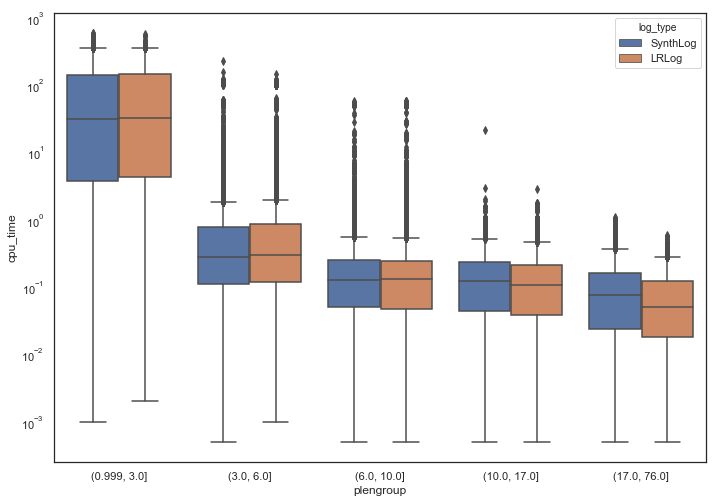

In [73]:
sns.boxplot(x="plengroup", y="cpu_time", hue="log_type",
                 data=sliced_plendf_coll)
plt.yscale('log')

In [75]:
3.46353e+06

3463530.0